PART 1: CREATING SKIN PATCH

Field size ~1mm^2 with 256 evenly dispersed (10% jitter) receptors

The goal of this file is to simulate a skin patch with randomly dispersed receptors. Once a stimulus is applied at a certain location on the skin patch, the nearby receptors should produce an output as defined by the function described in later sections. To train the somatosensory cortex model, a set of stimuli that cover the skin patch is also generated and applied to get the stimulus-specifc recetor outputs used to generate the external input component of the neuron firing function of the main simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# total number should allow for a square grid
total_receptors = 256
stimuli_set = 121
jitter = 0.1

# function takes in the total nr of points and creates a data frame with
# 5% jitter coordinates for all points
def create_coordinates(input_type, total, jitter):
    grid_size = int(np.sqrt(total))
    x_coords = np.linspace(0, 1, grid_size)
    y_coords = np.linspace(0, 1, grid_size)

    coordinates = []
    if input_type == "Stim":
        for i in x_coords:
            for j in y_coords:
                x_jittered = i + (np.random.normal(0, 1/grid_size) * jitter) # evenly dispersed
                y_jittered = j + (np.random.normal(0, 1/grid_size) * jitter)
                coordinates.append((x_jittered, y_jittered))
    else:
        for i in x_coords:
            for j in y_coords:
                x_jittered = i + np.random.normal(0, jitter) # more random
                y_jittered = j + np.random.normal(0, jitter)
                coordinates.append((x_jittered, y_jittered))

    return pd.DataFrame(coordinates, columns=["X", "Y"])

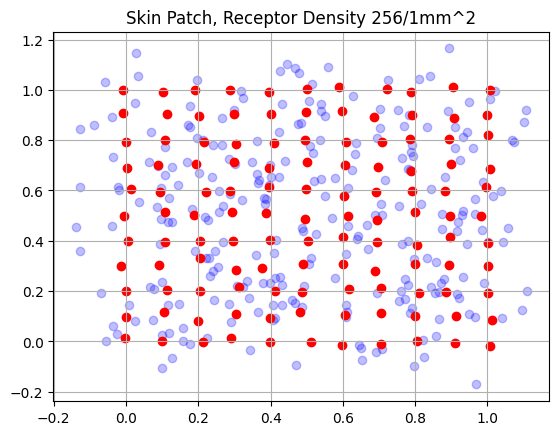

In [6]:
# use coordinate function to create random receptor grid and uniform stimuli set
stimuli_coordinates = create_coordinates("Stim", stimuli_set, jitter)
receptor_coordinates = create_coordinates(_, total_receptors, jitter)
# use these for getting test stims + .iloc[:, 0/1] in the plot (if creating new - .X or .Y)
    ## receptor_coordinates = pd.read_csv("receptor_outputs_0.csv", usecols=["Receptor_X", "Receptor_Y"], nrows=256)
    ## stimuli_coordinates.to_csv("RF_Stim_Coords.csv")

# Plot the points
plt.scatter(receptor_coordinates.X, receptor_coordinates.Y, color='blue', label='Receptors', alpha = 0.25)
plt.scatter(stimuli_coordinates.X, stimuli_coordinates.Y, color='red', label='Stimuli')
plt.title(f'Skin Patch, Receptor Density {total_receptors}/1mm^2')
plt.grid(True)
plt.show()

OUTPUT:

DataFrame with receptor coordinates ("X","Y") and DataFrame with stimuli coordinates ("X","Y"). When training, the stimuli set would be cycled through one by one to simulate applying pressure over the skin patch

PART 2: APPLYING STIMULI

A function is created to calculate output current for a single stimulated receptor, by specifying receptor and stimuli coordinates.
A second function applies a specified stimulus to all receptors, creating a dataframe receptor_outputs that is specific to a single stimuli. 

Merkel Ending Complexes (MEC) are responsible for touch and pressure senseation reception. Due to the mechanistic properties of the skin, the applied stimulus should be detected up to a certain range around the stimulus point, with further receptors producing decreasing output strenght. The following equation describes the reposne of a given receptor at (Rx,Ry) when a stimulus is presented at (X,Y):

                                S(Rx, Ry) = exp(-1/5sqrt(1/stdev((Rx-X)^2+(Ry-Y)^2)))

In [4]:
# calculating output current for receptor(Rx, Ry) when stimulus(X, Y) is applied
def calculate_output(Rx, Ry, X, Y):
    stdev = 0.0005
    squared_distance = (Rx - X)**2 + (Ry - Y)**2
    scaled_distance = np.sqrt(squared_distance / stdev)
    output = np.exp(-0.5 * scaled_distance)
    return output

# applying a single stimulus(X, Y) to all receptors on the skin patch
# creates a new stimulus-specific dataframe with receptor coordinates and the corresponding output value
def apply_stimulus(Sx, Sy):
    receptor_outputs = pd.DataFrame(columns=['Receptor_X', 'Receptor_Y', 'Output'])  # Initialize an empty DataFrame for outputs

    for index, row in receptor_coordinates.iterrows():
        output_value = calculate_output(row["X"], row["Y"], Sx, Sy) # perform calculations for each receptor
        new_row = pd.DataFrame({'Receptor_X': [row["X"]], 'Receptor_Y': [row["Y"]], 'Output': [output_value]})
        receptor_outputs = pd.concat([receptor_outputs, new_row], ignore_index=True)
    return receptor_outputs

OUTPUT:

Receptor Outputs DataFrame, containg X and Y coordinates of receptor and its response to a specified stimulus. All receptors on the skin patch output a value for the single specified stimulus

EXAMPLE AND RESULTS

Stimuli location:  0.6011961876011216 ; 0.4155099717919726


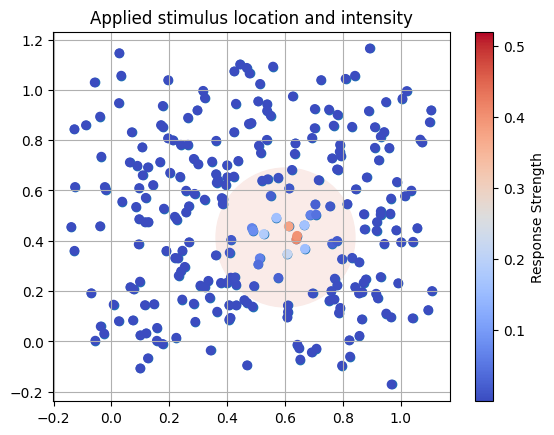

In [7]:
# Example usage
applied_stim = 70
stimulus_x = stimuli_coordinates.iloc[applied_stim]['X']
stimulus_y = stimuli_coordinates.iloc[applied_stim]['Y']
receptor_outputs = apply_stimulus(stimulus_x, stimulus_y)
print("Stimuli location: ", stimuli_coordinates.loc[applied_stim]["X"], ";", stimuli_coordinates.loc[applied_stim]["Y"] )


# VALIDATION
# plot for visualising stimulus location and intensity on receptor grid
plt.title("Applied stimulus location and intensity")
plt.scatter([stimulus_x], [stimulus_y], color="#faebe8",s = 10000, label="Stimulus")
plt.scatter(receptor_coordinates.X, receptor_coordinates.Y, label="Receptors")
sc = plt.scatter(receptor_outputs["Receptor_X"], receptor_outputs["Receptor_Y"], c=receptor_outputs["Output"], cmap="coolwarm", vmax = 0.52)
plt.colorbar(sc, label="Response Strength")
plt.grid(True)
plt.show()


Create a dataframe with the output for each receptor-stimulus pair. The output is a dataframe with each row representing a single receptor-stimulus pair - receptor X and Y coordinates, Output value, stimulus X and Y coordinates and stimulus indices (used for applying a single stimulus in cortex stimulation)

In [5]:
outputs = pd.DataFrame()
for index, row in stimuli_coordinates.iterrows():
        Sx, Sy = row["X"], row["Y"]
        receptor_outputs = apply_stimulus(Sx, Sy)
        receptor_outputs["Stimulus_X"] = Sx
        receptor_outputs["Stimulus_Y"] = Sy
        receptor_outputs["Stimulus_Index"] = index
        
        # Append to the combined dataframe
        outputs = pd.concat([outputs, receptor_outputs], ignore_index=True)
print(outputs)
outputs.to_csv("test_receptor_outputs8x8.csv")


       Receptor_X  Receptor_Y    Output  Stimulus_X  Stimulus_Y  \
0       -0.035836    0.273186  0.002839    0.003719    0.013926   
1       -0.021485   -0.166634  0.016965    0.003719    0.013926   
2        0.120615   -0.085900  0.032152    0.003719    0.013926   
3       -0.027574    0.248025  0.005086    0.003719    0.013926   
4       -0.061377    0.127898  0.053137    0.003719    0.013926   
...           ...         ...       ...         ...         ...   
16379    0.966614    0.643632  0.000516    0.990091    0.981313   
16380    0.992854    0.684764  0.001318    0.990091    0.981313   
16381    1.047297    0.928657  0.175775    0.990091    0.981313   
16382    1.050851    0.944685  0.204660    0.990091    0.981313   
16383    1.013963    0.944302  0.373514    0.990091    0.981313   

       Stimulus_Index  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
16379              63  
163

RESPONSE CURVE plotting for validation

In [59]:
# Response curve
# Calculate distances from stimulus
receptor_outputs["Distance"] = np.sqrt((receptor_outputs["X"] - stimulus_x)**2 + (receptor_outputs["Y"] - stimulus_y)**2)
receptor_outputs_sorted = receptor_outputs.sort_values(by='Distance')

# Plot scatter plot of individual receptor outputs vs. distance
plt.figure(figsize=(8, 6))
plt.scatter(receptor_outputs_sorted["Distance"], receptor_outputs_sorted["Output"], edgecolor="black")
plt.xlabel("Distance from Stimulus")
plt.ylabel("Output Strength")
plt.title("Receptor Response Curve")
plt.grid(True)
plt.show()